# Simulating Transaction Data
**Forefront Analytics, Feb 2018**  

This notebook was developed to test the new Amazon Web Services SageMaker service.  

We will simulate several years of POS transaction data for a hypothetical retail chain with stores located throughout Australia, to be written to an SQL database. We would like the data to exhibit realistic seasonal, weekly, hourly and geographic trends. These simulated transactions could then be used as a resource for developing ML models or data visualisation dashboards.  

To achieve these ends, we will rely on three open data sources to bootstrap the simulation process:
* [Australian Bureau of Statistics (ABS) Retail & Wholesale Trade data by month and state](http://www.abs.gov.au/Retail-and-Wholesale-Trade) --> choose 'Retail Trade'
  * TABLE 1. Retail Turnover, By Industry Group
  * TABLE 3. Retail Turnover, By State
* [Instacart Basket Data](https://www.kaggle.com/c/instacart-market-basket-analysis), open sourced through Kaggle  
  * order_products__prior.csv
  * products.csv
  * departments.csv
  * aisles.csv
* [Australian postcodes](http://www.corra.com.au/australian-postcode-location-data/)
  * Australian_Post_Codes_Lat_Lon.csv

**As a first step, download and extract all these datasets to an S3 bucket, and add the relative paths in the cell below.**

In [1]:
# S3 bucket to use
BUCKET_NAME = 'ff-sagemaker-test'

# Data files for ABS industry & state data and postcodes
INDUSTRY_DATA = 'abs-data/abs_monthly_industry.xls'
STATE_DATA = 'abs-data/abs_monthly_state.xls'

# Instacart data for transactions, products, departments (category) and aisles (subcat)
TRANSACTIONS = 'instacart-data/order_products__prior.csv'
PRODUCTS = 'instacart-data/products.csv'
DEPARTMENTS = 'instacart-data/departments.csv'
AISLES = 'instacart-data/aisles.csv'

POSTCODES = 'postcodes.csv'

# Output file for final SQL queries
SQL_TABLE = 'simulated-pos-data'
OUTPUT_FILE = 'output.txt'

Next, we'll import all the libraries that need for the coming steps

In [2]:
import calendar
import io
from datetime import date, datetime

import boto3    # The Amazon Web Services SDK for accessing S3, EC2 etc.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from readlines import readlines

# Because we love 538's style
plt.style.use('fivethirtyeight')

Data on Australian historical monthly retails trends, covering up to November 2017, were accessed on 20 February 2018 and saved to the S3 bucket listed above. More recent data may be available - if so, it can be accessed from the URLs below and saved to S3.

[Stable list of datasets](http://www.abs.gov.au/Retail-and-Wholesale-Trade)  

Latest datasets at time of writing:  
[All datasets](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/8501.0Dec%202017?OpenDocument)  
[Industry-specific data](http://www.abs.gov.au/ausstats/meisubs.NSF/log?openagent&850101.xls&8501.0&Time%20Series%20Spreadsheet&962BE5A36396384ACA25822B000DD1F8&0&Dec%202017&06.02.2018&Latest)  
[State-specific data](http://www.abs.gov.au/ausstats/meisubs.NSF/log?openagent&850103.xls&8501.0&Time%20Series%20Spreadsheet&3F40170D14139032CA25822B000DD35D&0&Dec%202017&06.02.2018&Latest)

Boto3 is Amazon's Python SDK for accessing services such as S3 buckets. After establishing a resource connection we can, for example, view all our buckets or all the files in a given bucket.

In [3]:
# Create a connection to the S3 service
s3 = boto3.resource('s3')

# To list all available buckets
print('Buckets:')
for bucket in s3.buckets.all():
    print(bucket.name)

# To list all available objects in a bucket
print('\nBucket Objects:')
bucket = s3.Bucket(BUCKET_NAME)
for object in bucket.objects.all():
    print(object)

Buckets:
aws-logs-518761725582-ap-southeast-2
ff-sagemaker-test

Bucket Objects:
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='abs-data/')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='abs-data/abs_monthly_industry.xls')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='abs-data/abs_monthly_state.xls')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='instacart-data/')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='instacart-data/aisles.csv')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='instacart-data/departments.csv')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='instacart-data/order_products__prior.csv')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='instacart-data/products.csv')
s3.ObjectSummary(bucket_name='ff-sagemaker-test', key='postcodes.csv')


### Generating Monthly Transaction Counts
We will read in the ABS industry trade data to get a sense of historical retails trends in Australia, and use this to determine numbers of transactions for each state for each hour of each day. Luckily the ABS data is extremely clean, so there is no wrangling needed other than specifying which parts to read in.

In [4]:
def read_industry_df():
    # Create a connection to the industry XLS data object on S3 and get object
    industry_obj = s3.Object(bucket_name=BUCKET_NAME, key=INDUSTRY_DATA)
    industry_response = industry_obj.get()

    # File will be read into an in-memory bytestream
    file_obj = io.BytesIO(industry_response['Body'].read())

    # Then into a Pandas dataframe, skipping header rows, derived columns, and renaming columns
    rows_to_skip = list(range(1, 10))
    cols_to_use = list(range(7))
    workbook_name = 'Data1'
    col_names=['Food', 'Household goods', 'Clothing', 'Department stores', 'Other', 'Restaurants', 'Total']
    df = pd.read_excel(file_obj, workbook_name, skiprows=rows_to_skip, usecols=cols_to_use, names=col_names)
    return df

industry_df = read_industry_df()
industry_df.head()

,Food,Household goods,Clothing,Department stores,Other,Restaurants,Total
1982-04-01,1162.6,592.3,359.9,460.1,479.1,342.4,3396.4
1982-05-01,1150.9,629.6,386.6,502.6,486.1,342.1,3497.9
1982-06-01,1160.0,607.4,350.5,443.8,467.5,328.7,3357.8
1982-07-01,1206.4,632.4,359.3,459.1,491.1,338.5,3486.8
1982-08-01,1152.5,622.6,325.2,438.4,485.7,331.5,3355.9


Figures are provided by industry sector. We'll use the data for restaurants and cafes to model our seasonal fluctuations, but any of these (or the total) could be used to model changes in Australian over time.  

Additionally, we only want to generate three years of transaction data, so we'll restrict the data frame to the most recent three years.

In [5]:
NUM_YEARS = 3

def extract_series(df, col_to_use='Restaurants'):
    # Define the end and start dates to use (the full dataset spans to the '80s)
    end = industry_df.index[-1].date()
    start = date(end.year - NUM_YEARS, end.month, 1)

    # Subset data to Restaurants for the last 3 years only
    monthly_s = df[col_to_use]
    return monthly_s.loc[start:end]
    
monthly_s = extract_series(industry_df)
monthly_s.head()

2014-11-01    3374.9
2014-12-01    3692.7
2015-01-01    3391.3
2015-02-01    3027.5
2015-03-01    3361.9
Name: Restaurants, dtype: float64

Looks pretty good. Let's quickly plot that to see what kind of trend we're dealing with.

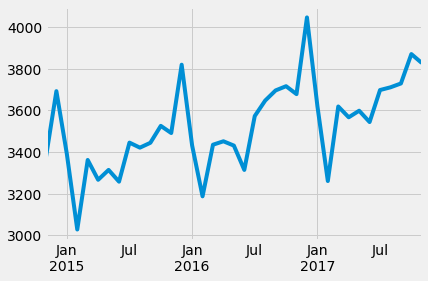

In [6]:
monthly_s.plot()
plt.show()

We see a nice cyclical pattern with a clear peak in December, an annual low in February, another dip in June and climbing through to December. Additionally, there's a clear annual growth in the industry.  

This data frame offers a solid starting point from which to simulate realistic transaction data. We of course face some limitations regarding **time granularity**: i.e. we have no information about economic breakdown by week of the month, day of the week or hour of the day. We'll address these issues step by step.  

Another issue will be figuring out how to realistically distribute our transactions amongst states and stores within states. As a first step, let's convert the raw ABS data into numbers of transactions.

In [7]:
# Simulate an average of a million transactions per year.
# This will need to take into account the annual growth rate seen.
def convert_to_transactions(monthly_series, trans_per_year=1000000):
    # Calculate total economic activity for our time period
    total_activity = monthly_series.sum()

    # Determine number of transactions to simulate across our 3-year period
    num_transactions = trans_per_year * NUM_YEARS

    # Divide transactions among months proportionate to each month's economic activity
    # Transactions per month will be float which is clearly impossible
    # But we'll round this after divvying them up into the smallest time unit
    return monthly_series / total_activity * num_transactions 

transaction_s = convert_to_transactions(monthly_s)
print("Transactions per month:")
print(transaction_s.head(5))

Transactions per month:
2014-11-01    77588.188774
2014-12-01    84894.338998
2015-01-01    77965.221070
2015-02-01    69601.541234
2015-03-01    77289.321710
Name: Restaurants, dtype: float64


### Distributing Transactions Geographically 

We have retained the same shape of the data, and will be generating about several tens of thousands of transactions per month.  

The next thing to do is distribute these transactions among the states and territories of Australia where our hypothetical company has stores. Further, we want this distribution to realistically reflect the economic activity of each state. ABS provides monthly data by state which we could use to capture fluctuations in the relative activity of restaurants & cafes by state. However, as we are just simulating rough data and anticipate proportional growth over time between each state's restaurant economy, we'll instead use the much smaller and simpler state-wide data set, and guide growth by the monthly dataset.

In [8]:
def read_state_df():
    # Create a connection to the state XLS data object on S3 and get object
    state_obj = s3.Object(bucket_name=BUCKET_NAME, key=STATE_DATA)
    state_response = state_obj.get()

    # XLS file will be read into an in-memory bytestream
    file_obj = io.BytesIO(state_response['Body'].read())

    # Then into a Pandas dataframe, skipping header rows, derived columns, and renaming columns
    rows_to_skip = list(range(1, 10))
    cols_to_use = list(range(8))
    workbook_name = 'Data1'
    col_names=['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT']
    df = pd.read_excel(file_obj, workbook_name, skiprows=rows_to_skip, usecols=cols_to_use, names=col_names)
    return df

state_df = read_state_df()
state_df.head()

,NSW,VIC,QLD,SA,WA,TAS,NT,ACT
1982-04-01,1250.2,916.2,486.3,279.4,298.3,79.9,NaN,57.1
1982-05-01,1300.0,931.2,492.8,288.0,318.5,78.9,NaN,57.3
1982-06-01,1234.2,887.0,494.1,277.2,301.5,77.5,NaN,55.3
1982-07-01,1265.0,921.3,515.6,296.1,316.4,82.7,NaN,56.3
1982-08-01,1217.6,883.2,501.4,288.4,300.5,78.1,NaN,55.4


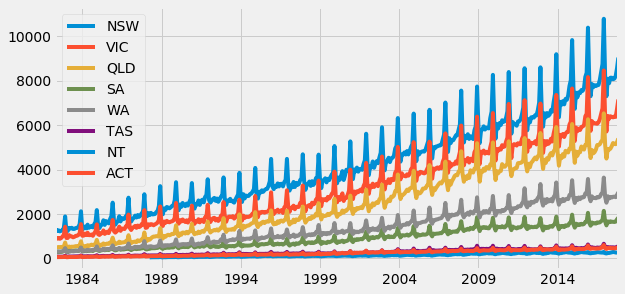

In [9]:
state_df.plot(figsize=(9, 4.5))
plt.show()

This is a pretty good validation of our simplifying assumption that the ratio of economic activity stays constant over time between the states & territories.  

Next we will convert this to number of transactions per state for the last 3 years as above, and restrict to a subset of the available locations - our fictional company will have a presence in all states except SA, TAS and the NT.

In [10]:
def get_transactions_per_state(states_dataframe, monthly_transactions):
    # Subset columns (comment out to use all states)
    states_to_use=['NSW', 'VIC', 'QLD', 'WA', 'ACT']
    if states_to_use:
        states_dataframe = states_dataframe[states_to_use]
    else:
        states_to_use = states_dataframe.columns

    # Restrict to the relevant dates
    states_dataframe = states_dataframe.loc[monthly_transactions.index]

    # Derive total activity for each month and add in the transactions
    states_dataframe['total'] = states_dataframe.sum(axis=1)
    states_dataframe['transactions'] = monthly_transactions

    # Distribute transactions among states proportionate to economic activity
    print("Fraction of activity at latest time point")
    for state in states_to_use:
        economic_fraction = states_dataframe[state] / states_dataframe['total']    
        print(f"{state}: {economic_fraction[-1]:.1%}")
        states_dataframe[state] = economic_fraction * states_dataframe['transactions']

    # Drop unnecessary columns
    res = states_dataframe.drop(labels=['total', 'transactions'], axis=1)
    return res

state_trans = get_transactions_per_state(state_df, transaction_s)

Fraction of activity at latest time point
NSW: 36.1%
VIC: 28.5%
QLD: 21.5%
WA: 11.9%
ACT: 2.0%


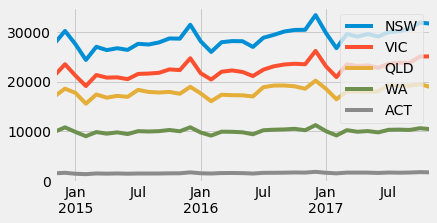

In [11]:
state_trans.plot(figsize=(6, 3))
plt.show()

### Distribute Transactions by Day and Hour

Now that we have numbers of transactions per state per month, we need to distribute these into days then hours (we could go further to minutes and even seconds if we needed to analyse at this level).  

Depending on the type of company, sales will likely vary predictably by day of the week (e.g. if the store doesn't open on weekends, there should be no transactions on those days).  

There are a number of ways we could do this, but for simplicity we will define a base proportion of transactions for each day of the week, and sprinkle on some randomness to make it more realistic. For even more complex results we could vary these rates by state (or better yet by individual store), which would allow anomaly detection-style analyses.  

Note that we'll likely get unrealistically similar averages for all weeks within a given month. This could be avoided by e.g. distributing weekly averages within a given month linearly from the the preceding and following month values, but again for simplicity this approach should be fine.

In [12]:
# Define proportion of transactions for each day of the week (should sum to 1).
# Here transactions build throughout the week til Friday, then weekends are quieter
DAY_PROBS = {
    0: 0.139,    # Monday
    1: 0.151,    # Tuesday
    2: 0.161,    # Wednesday
    3: 0.188,    # Thursday
    4: 0.186,    # Friday
    5: 0.101,    # Saturday
    6: 0.074     # Sunday
}

# Because of floating point error can't simply check sum == 1
assert abs(sum(DAY_PROBS.values()) - 1) < 0.0001, f"Probabilities sum to {sum(day_prob.values())}, should = 1"

Now to consider the randomness. It's reasonable to use a normal distribution to add some noise to the number of transactions that occur on any given day. Higher values for the sigma parameter give a wider spread and lower values will give a tighter distribution. Let's see, for any given Monday, the spread of values that result from a sigma of 0.15, setting aside for the moment seasonal variation.

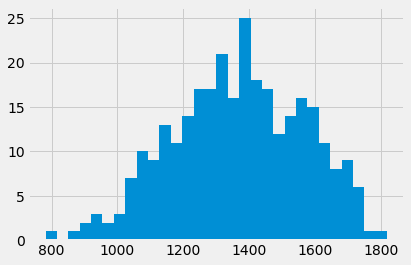

In [13]:
# number of Mondays to simulate, average transactions per week, variance
def explore_random_distribution(num_mondays=300, weekly_trans=10000, sigma = 0.15):               
    randomnesses = 1 + sigma * np.random.randn(num_mondays)
    monday_transactions = [weekly_trans * DAY_PROBS[0] * randomnesses[i] for i in range(num_mondays)]

    n, bins, patches = plt.hist(monday_transactions, 30)
    plt.show()

explore_random_distribution()

This seems like a plausible spread.  

Now we can generate daily transaction counts for each state by combining the monthly averages, daily probabilities defined above, and sampling from a random normal distribution.

In [14]:
def get_daily_transactions(monthly_state_transactions, sigma=0.15):
    # Initialise an empty dataframe which we will feed daily entries
    df = pd.DataFrame(columns=monthly_state_transactions.columns)
    num_states = len(monthly_state_transactions.columns)

    # Iterate through monthly transaction counts for all states
    for row in monthly_state_transactions.iterrows():
        monthdate, num_transactions = row[0], row[1]

        # Get number of days & weeks in the month (don't care what the first day of the month is)
        _, num_days = calendar.monthrange(monthdate.year, monthdate.month)
        num_weeks = num_days / 7
        # Get transactions per week per state for this month
        num_weekly_trans = num_transactions / num_weeks

        # Divide weekly transactions among days according to daily probability
        for day in range(1, num_days + 1):
            datey = datetime(monthdate.year, monthdate.month, day)
            day_of_week = datey.weekday()

            # Add randomness so a given weekday isn't identical within month
            randomness = 1 + sigma * np.random.randn(num_states)
            day_trans = DAY_PROBS[day_of_week] * num_weekly_trans * randomness
            day_trans.name = datey
            # Convert to integer count of transactions
            df = df.append(day_trans)
    return df

daily_df = get_daily_transactions(state_trans)

Let's check what the daily transaction numbers look like for the final 2 months.

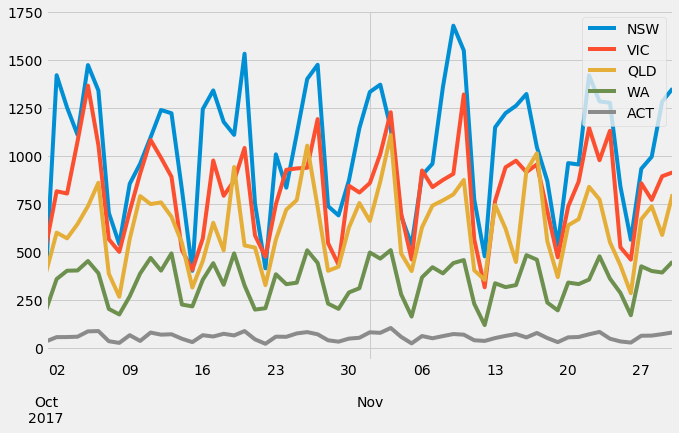

In [15]:
daily_df.iloc[-61:].plot(figsize=(10, 6))
plt.show()

One caution is that, using the ABS data and the number of yearly transactions we specified above, the activity in ACT is quite low, possibly less than we would expect to see for even a single store (depending on the type of company we're simulating). If this is a problem, it might be worth boosting the total number of transactions, removing the ACT from the mix or artificially boosting numbers of transactions there.  

As a final check before proceeding, if we reconstitute monthly totals, the graph should look similar to the original state-trans.

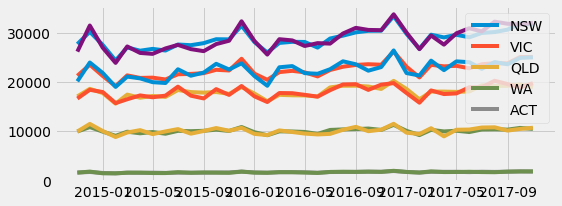

In [16]:
# Copy data frame and aggregate back to months
def test_reaggregating_days(daily_dataframe, monthly_dataframe):
    test_daily = daily_dataframe.copy()
    # Group days back to months and reindex
    test_daily['month'] = test_daily.index.map(lambda x: x.month)
    test_daily['year'] = test_daily.index.map(lambda x: x.year)
    test_daily = test_daily.groupby(['year', 'month']).sum()
    test_daily['date'] = test_daily.index.map(lambda x: datetime(x[0], x[1], 1))
    test_daily = test_daily.set_index('date')

    plt.figure(figsize=(8,3))
    plt.plot(monthly_dataframe)
    plt.plot(test_daily)
    plt.legend(state_trans.columns)
    plt.show()

test_reaggregating_days(daily_df, state_trans)

The trajectories are recreated plus or minus the randomness injected into daily transaction numbers, so we're happy to move on.

The final step is splitting our daily transactions into hours. Once again there are a few ways this could be achieved. Here we have relied on some internal data to get the proportion of transactions each hour of the day is hardcoded to give two peaks, a large one around 10am and a smaller one around 5pm.

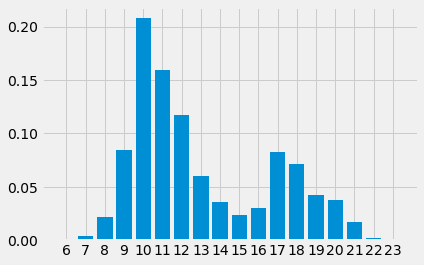

In [17]:
HOUR_PROBS = [
    (6, 0.001),
    (7, 0.004),
    (8, 0.022),
    (9, 0.085),
    (10, 0.208),
    (11, 0.159),
    (12, 0.117),
    (13, 0.06),
    (14, 0.036),
    (15, 0.024),
    (16, 0.03),
    (17, 0.083),
    (18, 0.071),
    (19, 0.042),
    (20, 0.038),
    (21, 0.017),
    (22, 0.002),
    (23, 0.001)
]

def visualise_hourly_probs():
    # Convert hours and probabilities to lists
    hours = [hour for hour, _ in HOUR_PROBS]
    probs = [prob for _, prob in HOUR_PROBS]

    assert abs(sum(probs) - 1) < 000.1, f"Error: Hour probs are {sum(hour_probs.values())}"
    plt.bar(hours, probs)
    plt.xticks(hours)
    plt.show()

visualise_hourly_probs()

Depending on the number of transactions being generated, this step can take a bit longer. For 3 years of data and a million transactions per year, it will likely require about a minute.

In [18]:
%%time

def get_hourly_transactions(daily_dataframe):
    # Initialise empty dataframe to take hourly records
    df = pd.DataFrame(columns=daily_df.columns)
    num_cols = len(daily_df.columns)

    # Iterate through rows of daily state data, distribute into hourly rows
    for row in daily_dataframe.iterrows():
        daydate, num_transactions = row[0], row[1]
        for hour, prob in HOUR_PROBS:
            datey = datetime(daydate.year, daydate.month, daydate.day, hour)

            # We use a normal random function with slightly lower variance than before
            randomness = 1 + 0.10 * np.random.randn(num_cols)
            hour_trans = num_transactions * prob * randomness
            hour_trans.name = datey
            # Round to nearest int
            hour_trans = hour_trans.apply(lambda x: int(round(x)))
            df = df.append(hour_trans)
    return df

hourly_df = get_hourly_transactions(daily_df)

CPU times: user 47.4 s, sys: 52 ms, total: 47.4 s
Wall time: 47.3 s


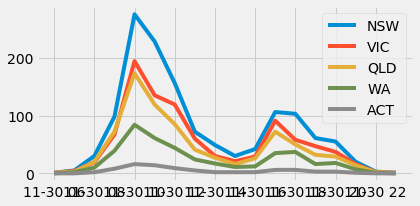

In [19]:
plt.figure(figsize=(6,3))
plt.plot(hourly_df.tail(18))
plt.legend(hourly_df.columns)
plt.show()

### Generating Store Locations

We're now ready to generate information about stores for each state, which will be used for distributing the transactions. We could provide a dictionary defining the number of stores to generate for each state, but to make it easier we'll just define a **total** number of stores to generate, and distribute these according to state economic activity, making sure there is at least 1 in each.  

We can randomly sample suburbs from a CSV file of all suburbs in Australia to determine store locations within a state.

In [20]:
# Read in postcodes
def read_postcodes():
    postcodes_obj = s3.Object(bucket_name=BUCKET_NAME, key=POSTCODES)
    postcodes_response = postcodes_obj.get()

    # CSV file will be read into an in-memory bytestream
    file_obj = io.BytesIO(postcodes_response['Body'].read())

    # Then into a Pandas dataframe, skipping header rows, derived columns, and renaming columns
    df = pd.read_csv(file_obj)
    return df

postcodes_df = read_postcodes()
postcodes_df.head()

,postcode,suburb,state,lat,long
0,200,AUSTRALIAN NATIONAL UNIVERSITY,ACT,-35.277272,149.117136
1,221,BARTON,ACT,-35.201372,149.095065
2,800,DARWIN,NT,-12.801028,130.955789
3,801,DARWIN,NT,-12.801028,130.955789
4,804,PARAP,NT,-12.432181,130.843310


In [21]:
def generate_stores(transactions_by_state, postcodes, total_stores=30):

    # Get total economic activity per state, and overall total
    state_sum = transactions_by_state.sum()
    grand_total = state_sum.sum()

    # Round number of transactions to nearest integer - may not get exact number  supplied
    state_sum = state_sum.apply(lambda x: round(x / grand_total * total_stores))
    # Add a store if rounded down to 0 in any state
    state_sum.replace(0, 1, inplace=True)

    # Read in postcodes
    stores = {}
    for state, num_stores in state_sum.iteritems():
        # Subset suburbs from current state
        state_postcodes = postcodes[postcodes['state'] == state][['postcode', 'suburb']]
        stores_sample = state_postcodes.sample(num_stores)

        # Use the CSV index as a unique store ID
        stores_sample['store_id'] = stores_sample.index
        stores[state] = stores_sample

    return stores

stores_dict = generate_stores(state_trans, postcodes_df)
print('Stores generated for Victoria')
stores_dict['VIC']

Stores generated for Victoria


,postcode,suburb,store_id
8348,3962,CHRISTIES,8348
6720,3461,LYONVILLE,6720
6475,3381,BELLFIELD,6475
7956,3840,HAZELWOOD NORTH,7956
6572,3407,GATUM,6572
8009,3851,SEASPRAY,8009
7551,3691,BONEGILLA,7551
5592,3130,BLACKBURN NORTH,5592


### Building the Catalogue

After all this work we're still missing the most important thing - the actual items in each transaction! Luckily there is an excellent open dataset of sales basket data, courtesy of Kaggle and Instacart.

https://www.kaggle.com/c/instacart-market-basket-analysis

We will read in these data files to build a product catalogue, then sample from real transactions to flesh out our time series. There are 3 files to build the catalogue then a 4th for the transactions:
- products.csv
- departments.csv (~product category)
- aisles.csv (~product sub-category)

In [22]:
def read_transaction_files():
    dfs = []
    for key in [PRODUCTS, DEPARTMENTS, AISLES]:
        obj = s3.Object(bucket_name=BUCKET_NAME, key=key)
        response = obj.get()
        dfs.append(pd.read_csv(io.BytesIO(response['Body'].read())))
    return dfs

products_df, departments_df, aisles_df = read_transaction_files()

In [23]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [24]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [25]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


We can now join the dataframes together on the basis of their unique keys. Unfortunately price information isn't provided in the dataset, and there are almost 50,000 items to contend with. As a simple way to deal with this, we will generate a random price for each item by sampling from a random gamma distribution (a continuous distribution lower bounded by 0 which can be skewed in interesting and useful ways depending on two 'shape' and 'scale' parameters).  

These parameters can be tweaked in diverse ways. Here we've picked a shape of 2 and scale of 4.

Median: $6.72
Mean: $8.07
Min: $0.04
Max: $48.54


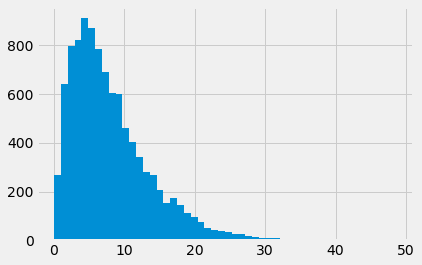

In [26]:
def explore_price_spread(shape=2, scale=4):
    x = np.random.gamma(shape, scale, 10000)
    print("Median: ${:.2f}".format(np.median(x)))
    print("Mean: ${:.2f}".format(sum(x) / len(x)))
    print("Min: ${:.2f}".format(min(x)))
    print("Max: ${:.2f}".format(max(x)))
    n, bins, patches = plt.hist(x, 50)
    plt.show()

explore_price_spread()

This distribution should provide vaguely reasonable pricing for food items, though of course strange things such as $20 eggs are entirely possible.

In [27]:
def build_catalogue(products_dataframe, departments_dataframe, aisles_dataframe, shape=2, scale=4):
    catalogue = pd.merge(products_dataframe, departments_dataframe, on='department_id')
    catalogue = pd.merge(catalogue, aisles_dataframe, on='aisle_id')

    # No longer need "id" key columns for department and aisle
    catalogue.drop(labels=['department_id', 'aisle_id'], axis=1, inplace=True)
    catalogue.columns = ['item_id', 'item_description', 'item_category',
                         'item_subcategory']
    catalogue.set_index('item_id', inplace=True)

    # Make item descriptions and categories Title Case
    catalogue = catalogue.applymap(lambda x: x.title())

    # Assign prices to the catalogue
    prices = np.random.gamma(shape, scale, catalogue.shape[0])
    prices = [round(price, 2) for price in prices]
    catalogue['price'] = pd.Series(prices)

    return catalogue

CATALOGUE = build_catalogue(products_df, departments_df, aisles_df)

In [28]:
print(CATALOGUE.shape)
CATALOGUE.sample(5)

(49688, 4)


,item_description,item_category,item_subcategory,price
item_id,,,,
45679,Gluten Free Cheddar Macaroni & Cheese Rice Pasta,Dry Goods Pasta,Instant Foods,10.33
15661,"Pull-Ups® Training Pants, Night Time For Boys ...",Babies,Diapers Wipes,12.31
4247,Peppermint Stick 70% Dark Chocolate,Snacks,Candy Chocolate,15.42
16425,Organic Lowafat 1% Milk,Dairy Eggs,Milk,10.45
13494,Peanut Butter Cookie Luna Bar,Snacks,Energy Granola Bars,16.95


## Generating Transactions

We're finally ready to start sampling from our catalogue and applying concrete line items for all the transactions we want to simulate.  

We will do this by using two functions: a main loop function to iterate through all the transactions that need to be generated for each store for each hour of each day, and a second one to create a single line item of a transaction.  

The second function is implemented to write each line item as an SQL INSERT statement to a document.  
This could be modified so that it connects to an SQL database and injects the statement directly.

In [29]:
# Map the datetime day of week integer to corresponding day
DAY_MAPPING = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

Here's the database schema we'll generate SQL statements for. Note that the database is very much not normalised, and in production one might wish reduce redundancy and simplify the query and/or split it into a number of tables.


Column Name      | Data Type | Description
-----------------|-----------|----------------------
Transaction ID   | SMALLINT  | Unique transaction ID 
Date             | DATE      | Date
Day of Week      | VARCHAR   | Day of week
Day type         | CHAR (2)  | W/day (WD) or w/end (WE)
Store ID         | SMALLINT  | Unique store ID
Location         | VARCHAR   | Suburb
Postcode         | SMALLINT  | Postcode
State            | CHAR (3)  | State of Australia
Item ID          | SMALLINT  | Unique item ID
Item Category    | VARCHAR   | Item category
Item Subcategory | VARCHAR   | Item subcategory
Item Description | VARCHAR   | Item description
Price            | DECIMAL   | Price of single item
Quantity         | TINYINT   | Quantity of item
Total Cost       | DECIMAL   | Total cost

In [30]:
def add_line_item(transaction_id, trans_datetime, state, item_id):
    """Generate a SQL entry for a single line item of a single transaction"""
    table = SQL_TABLE

    # Derive weekend and WD/WE
    weekday = DAY_MAPPING[trans_datetime.weekday()]
    day_type = 'WE' if trans_datetime.weekday() >= 5 else 'WD'

    # Pick a random store for the given transaction
    store = stores_dict[state].sample(1)
    store_id = store['store_id'].iloc[0]
    location = store['suburb'].iloc[0]
    postcode = store['postcode'].iloc[0]

    # Get item details from the catalogue
    item = CATALOGUE.loc[item_id]
    item_category = item['item_category']
    item_subcategory = item['item_subcategory']
    item_description = item['item_description']
    price = item['price']

    # Custom-define the probability of selling multiple of an item. Could draw from
    # a distribution, but should be skewed very hard towards single item sales.
    rando = np.random.random()
    if rando < 0.9:
        qty = 1
    elif rando < 0.95:
        qty = 2
    elif rando < 0.975:
        qty = 3
    elif rando < 0.988:
        qty = 4
    else:
        qty = 5

    # Output SQL queries to a document. Table schema is:
    # Transaction ID, Date, Day of Week, Day type, Store ID, Location, Postcode,
    # State, Item ID, Item Category, Item Subcategory, Item Description,
    # Price, Quantity, Total Cost
    with open(OUTPUT_FILE, 'a') as output:
        query = f"INSERT INTO `{table}` \n" \
                 f"VALUES ({transaction_id}, CAST({trans_datetime} AS DATETIME), "\
                 f"{weekday}, {day_type}, {store_id}, {location}, {postcode}, "\
                 f"{state}, {item_id}, {item_category}, {item_subcategory}, "\
                 f"{item_description}, {price}, {qty}, {price * qty});\n\n"

        output.write(query)

Here is the main function, which uses nested loops and reads from the transactions data source to generate numerous line items for each transaction.  

Note that the transactions CSV file is fairly large (~500MB), and as such we have used an approach that only reads one line at a time into memory. At present boto StreamingBody objects don't implement a readline() method, meaning it's not simple to achieve this. The helper function, readlines(), is defined in a separate .py document, and returns a generator for getting a line at a time from a StreamingBody.  

**NOTE:**  
If run completely, over 16 million SQL queries will be generated. For demonstration purposes we only iterate through one day of transactions (18 hours, ~15,000 transactions) here, but instructions are included below to generate all queries.

In [31]:
# If just want to process a sample of the datetime rows
HOURS_TO_PROCESS = 18

def build_transactions(hourly_df):
    """
    Main function to convert DataFrame of hourly transactions per state into a
    series of SQL insert statements.
    """
    transactions_generated = 0
    # Get a generator to read lines of the transactions CSV as a StreamingBody
    reader = readlines(s3, BUCKET_NAME, TRANSACTIONS)

    # Skip the headers and get first row
    _ = next(reader)
    transaction = next(reader)
    trans_id, item_id = int(transaction[0]), int(transaction[1])
    new_trans_id = trans_id

    # The states of Australia to iterate through
    states = hourly_df.columns

    # Iterator for datetime rows
    hourly_iterator = hourly_df.iterrows()
    # To process ALL transactions, comment out next 2 rows then uncomment 3rd
    for _ in range(HOURS_TO_PROCESS):
        hour_entry = next(hourly_iterator)
    # for hour_entry in hourly_iterator:
        datey, trans_per_state = hour_entry[0], hour_entry[1]
        print(f"Creating transactions for {datey}")

        # Iterate through index of states for given time
        for i, _ in enumerate(trans_per_state):
            # Iterate through each transaction
            for _ in range(trans_per_state[i]):
                # Multiple line items in a single transaction. Process together
                while new_trans_id == trans_id:
                    # Add a line item for given transaction
                    add_line_item(trans_id, datey, states[i], item_id)
                    transactions_generated += 1
                    transaction = next(reader)
                    new_trans_id, item_id = int(transaction[0]), int(transaction[1])

                # Update trans_id so next iteration can find if different transaction
                trans_id = new_trans_id
    print(f"\nTotal transactions generated: {transactions_generated:,} \n")

In [32]:
%%time
# Create transactions and save to output file
build_transactions(hourly_df)

Creating transactions for 2014-11-01 06:00:00
Creating transactions for 2014-11-01 07:00:00
Creating transactions for 2014-11-01 08:00:00
Creating transactions for 2014-11-01 09:00:00
Creating transactions for 2014-11-01 10:00:00
Creating transactions for 2014-11-01 11:00:00
Creating transactions for 2014-11-01 12:00:00
Creating transactions for 2014-11-01 13:00:00
Creating transactions for 2014-11-01 14:00:00
Creating transactions for 2014-11-01 15:00:00
Creating transactions for 2014-11-01 16:00:00
Creating transactions for 2014-11-01 17:00:00
Creating transactions for 2014-11-01 18:00:00
Creating transactions for 2014-11-01 19:00:00
Creating transactions for 2014-11-01 20:00:00
Creating transactions for 2014-11-01 21:00:00
Creating transactions for 2014-11-01 22:00:00
Creating transactions for 2014-11-01 23:00:00

Total transactions generated: 18,913 

CPU times: user 18.4 s, sys: 324 ms, total: 18.7 s
Wall time: 18.9 s


Let's have a peek at the first few queries generated

In [33]:
with open(OUTPUT_FILE, 'r') as sql_queries:
    for _ in range(9):
        print(sql_queries.readline(), end='')

INSERT INTO `simulated-pos-data` 
VALUES (2, CAST(2014-11-01 06:00:00 AS DATETIME), Saturday, WE, 1041, PATONGA, 2256, NSW, 33120, Dairy Eggs, Eggs, Organic Egg Whites, 14.41, 1, 14.41);

INSERT INTO `simulated-pos-data` 
VALUES (2, CAST(2014-11-01 06:00:00 AS DATETIME), Saturday, WE, 1998, MARSHDALE, 2420, NSW, 28985, Produce, Fresh Vegetables, Michigan Organic Kale, 3.5, 3, 10.5);

INSERT INTO `simulated-pos-data` 
VALUES (2, CAST(2014-11-01 06:00:00 AS DATETIME), Saturday, WE, 1041, PATONGA, 2256, NSW, 9327, Pantry, Spices Seasonings, Garlic Powder, 4.58, 1, 4.58);



There you have it!